In [1]:
import os

N_THREADS = "4"
os.environ["OMP_NUM_THREADS"] = N_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = N_THREADS
os.environ["MKL_NUM_THREADS"] = N_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = N_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = N_THREADS

import gEconpy as ge
import numpy as np
import pandas as pd
import gEconpy.plotting as gp
import matplotlib.pyplot as plt
import arviz as az
from corner import corner

import pymc as pm
from pymc.model.transform.optimization import freeze_dims_and_data

import preliz as pz
import nutpie as ntp

In [5]:
gcn_file = "../GCN Files/sims_2024/nk_taylor_rule_stick_wage_capital.gcn"
mod = ge.model_from_gcn(gcn_file, backend="pytensor", mode="JAX")

Model Building Complete.
Found:
	27 equations
	27 variables
		The following variables were eliminated at user request:
			D_t, TC_t, T_t, U_t, Y_j_t
		The following "variables" were defined as constants and have been substituted away:
			B_t
	6 stochastic shocks
		 0 / 6 has a defined prior. 
	20 parameters
		 18 / 20 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.



In [6]:
ge.check_steady_state(mod, pi_bar=1.001)

Steady state successfully found!


In [7]:
pi_bar_values = np.linspace(-0.005, 0.01, 100)
ss_pi_bar = pd.DataFrame(
    [mod.steady_state(pi_bar=1 + pi_bar, sigma=1.0) for pi_bar in pi_bar_values],
    index=pi_bar_values,
)

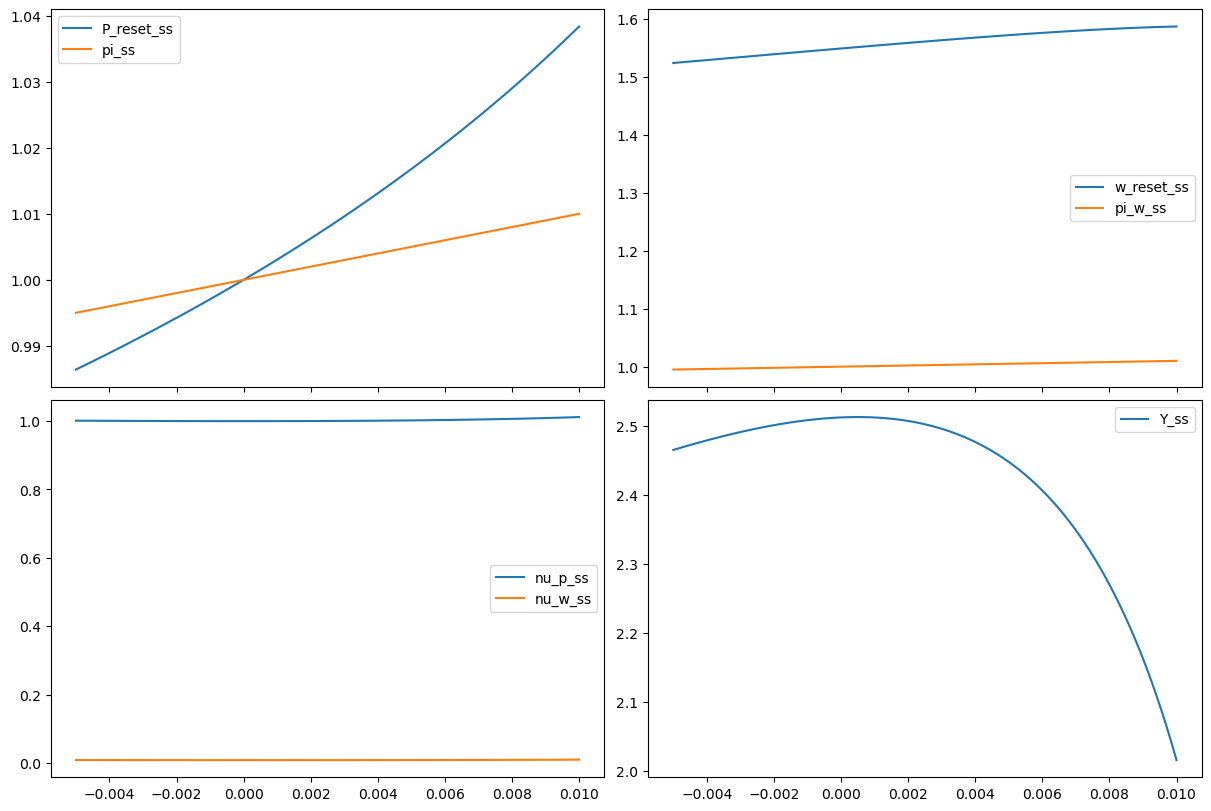

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, layout="constrained")
variables = [
    ["P_reset_ss", "pi_ss"],
    ["w_reset_ss", "pi_w_ss"],
    ["nu_p_ss", "nu_w_ss"],
    ["Y_ss"],
]

for var, axis in zip(variables, fig.axes):
    ss_pi_bar[var].plot(ax=axis)

plt.show()

In [9]:
irf_scenarios = {
    "both_sticky": {"phi_p": 0.75, "phi_w": 0.75},
    "prices_sticky": {"phi_p": 0.75, "phi_w": 0.0},
    "wages_sticky": {"phi_p": 0.0, "phi_w": 0.75},
}

shock_size = {
    "epsilon_i": 0.0025,
    "epsilon_G": 0.01,
    "epsilon_A": 0.01,
    "epsilon_pi_obj": 0.001,
}

In [10]:
irfs = {
    name: ge.impulse_response_function(
        mod,
        **scenario_params,
        shock_size=shock_size,
        simulation_length=20,
        not_loglin_variables=["i", "pi", "pi_obj"],
        verbose=False,
    ).isel(time=slice(1, None))
    for name, scenario_params in irf_scenarios.items()
}

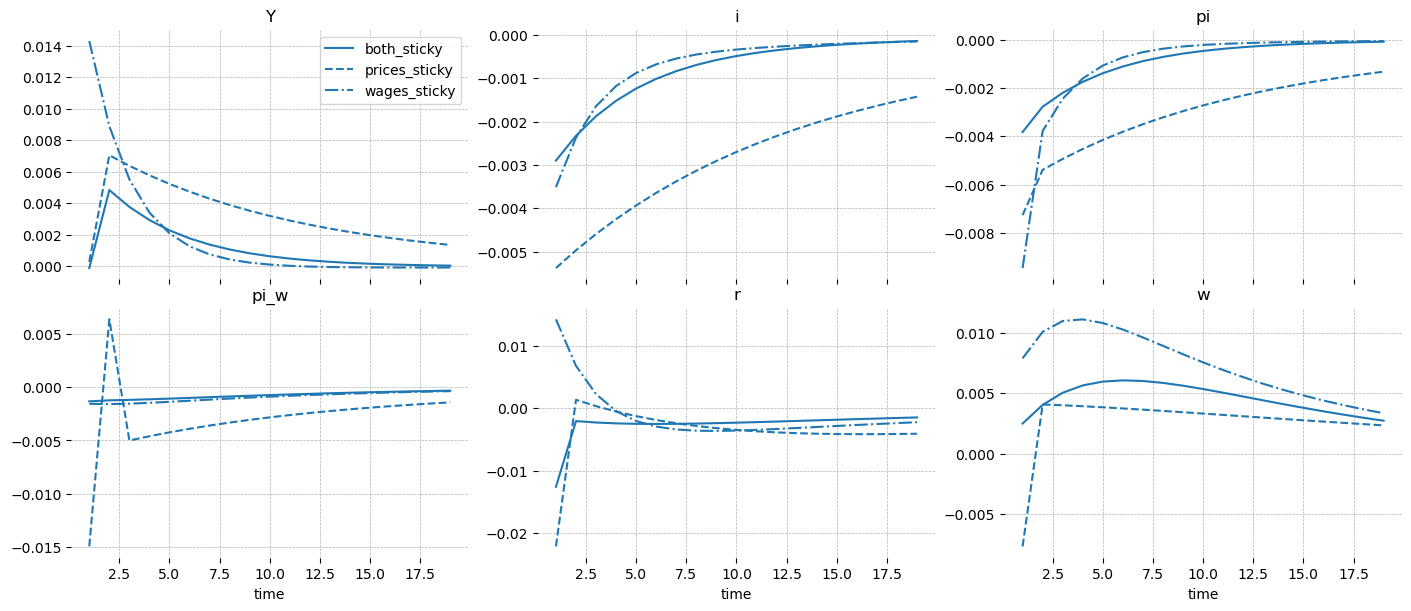

In [11]:
gp.plot_irf(
    irfs,
    vars_to_plot=["Y", "i", "pi", "pi_w", "r", "w"],
    shocks_to_plot=["epsilon_A"],
    n_cols=3,
    figsize=(14, 6),
);

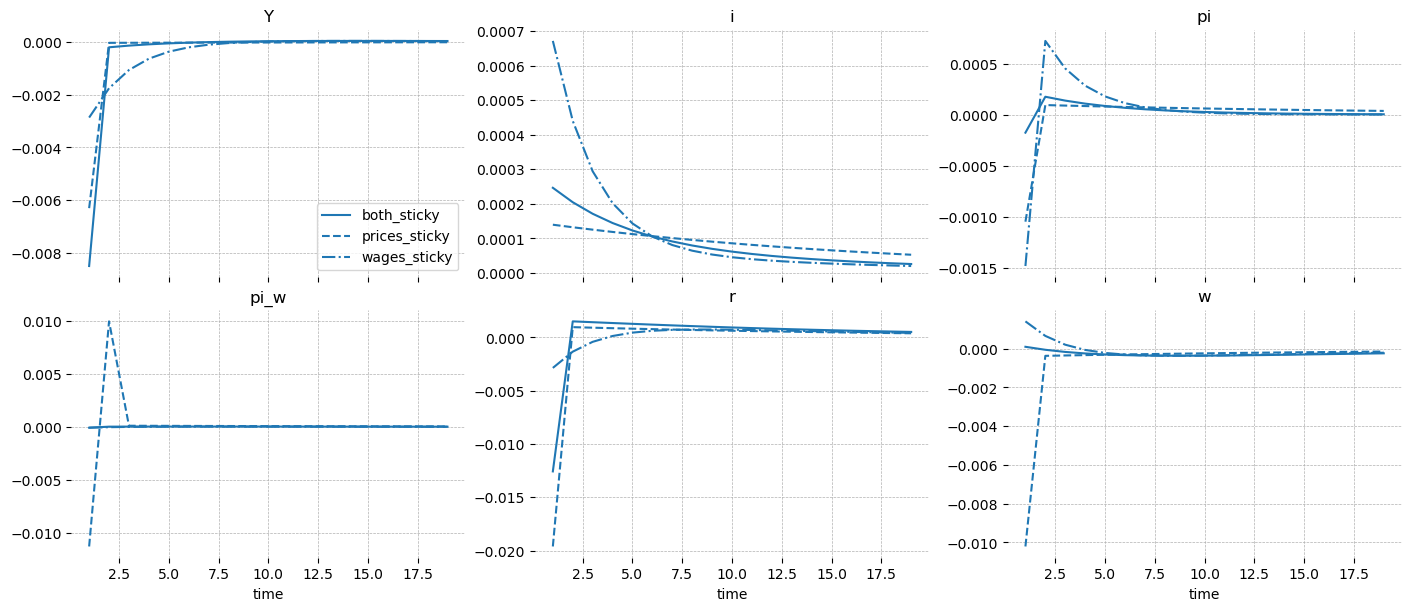

In [12]:
gp.plot_irf(
    irfs,
    vars_to_plot=["Y", "i", "pi", "pi_w", "r", "w"],
    shocks_to_plot=["epsilon_i"],
    n_cols=3,
    figsize=(14, 6),
);

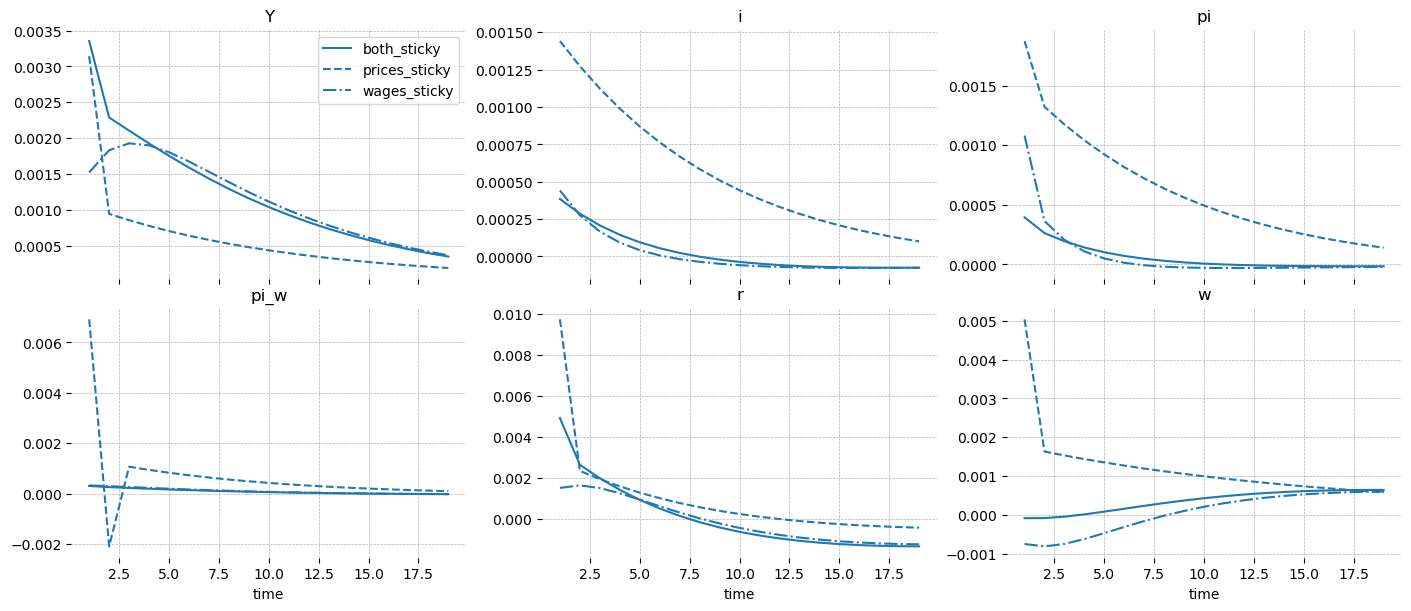

In [13]:
gp.plot_irf(
    irfs,
    vars_to_plot=["Y", "i", "pi", "pi_w", "r", "w"],
    shocks_to_plot=["epsilon_pi_obj"],
    n_cols=3,
    figsize=(14, 6),
);

In [14]:
ss_mod = ge.statespace_from_gcn(gcn_file, not_loglin_variables=["i", "pi", "pi_obj"])

Model Building Complete.
Found:
	27 equations
	27 variables
		The following variables were eliminated at user request:
			D_t, TC_t, T_t, U_t, Y_j_t
		The following "variables" were defined as constants and have been substituted away:
			B_t
	6 stochastic shocks
		 0 / 6 has a defined prior. 
	20 parameters
		 18 / 20 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.

Statespace model construction complete, but call the .configure method to finalize.


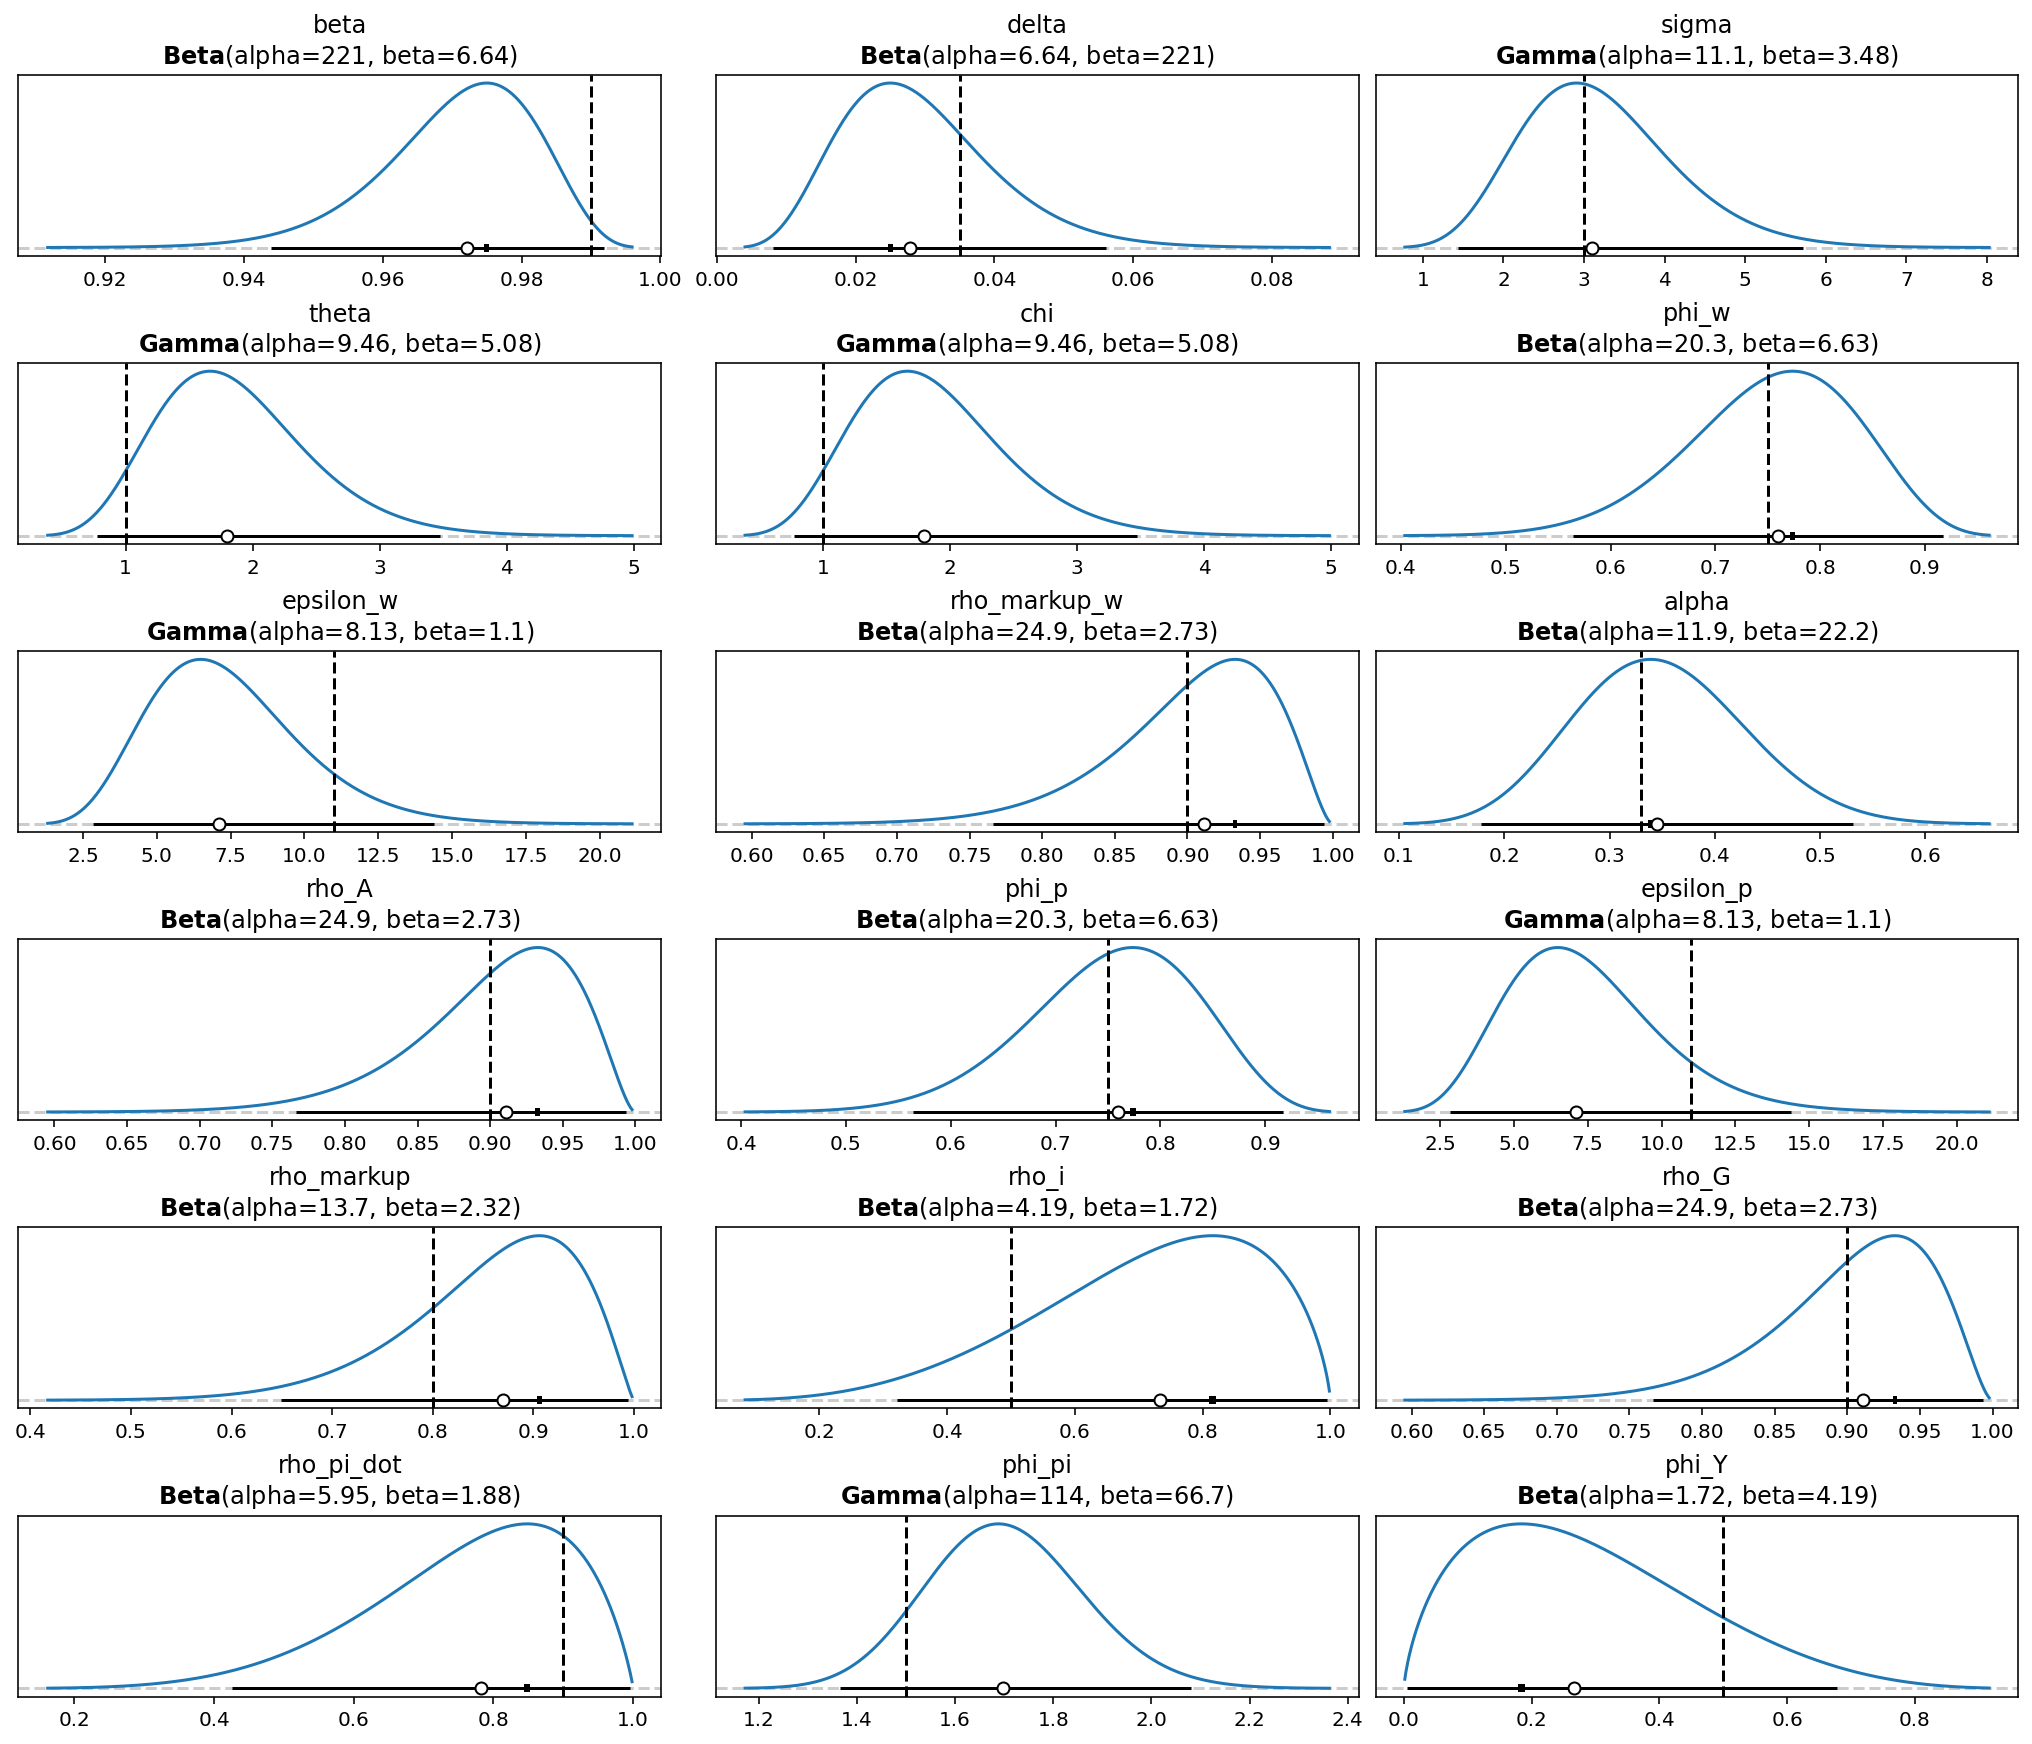

In [15]:
gp.plot_priors(ss_mod, n_cols=3);

In [16]:
ss_mod.configure(
    observed_states=["Y", "C", "I", "N", "pi", "i", "w", "r"],
    measurement_error=["Y", "C", "I", "N", "w", "r"],
    constant_params=["pi_bar", "psi"],
    full_shock_covaraince=True,
    solver="scan_cycle_reduction",
    mode="JAX",
    max_iter=20,
    use_adjoint_gradients=True,
)

The following parameters should be assigned priors inside a PyMC model block: 
	alpha -- shape: (), constraints: None, dims: None
	beta -- shape: (), constraints: None, dims: None
	chi -- shape: (), constraints: None, dims: None
	delta -- shape: (), constraints: None, dims: None
	epsilon_p -- shape: (), constraints: None, dims: None
	epsilon_w -- shape: (), constraints: None, dims: None
	phi_Y -- shape: (), constraints: None, dims: None
	phi_p -- shape: (), constraints: None, dims: None
	phi_pi -- shape: (), constraints: None, dims: None
	phi_w -- shape: (), constraints: None, dims: None
	rho_A -- shape: (), constraints: None, dims: None
	rho_G -- shape: (), constraints: None, dims: None
	rho_i -- shape: (), constraints: None, dims: None
	rho_markup -- shape: (), constraints: None, dims: None
	rho_markup_w -- shape: (), constraints: None, dims: None
	rho_pi_dot -- shape: (), constraints: None, dims: None
	sigma -- shape: (), constraints: Positive, dims: None
	theta -- shape: (), constr

In [17]:
n_shocks = ss_mod.k_posdef

A_params = pz.maxent(pz.Gamma(), lower=0.01, upper=0.1, plot=False).params_dict
other_params = pz.maxent(pz.Gamma(), lower=0.001, upper=0.01, plot=False).params_dict

sd_dist = pm.Gamma.dist(
    alpha=[A_params["alpha"]] + [other_params["alpha"]] * (n_shocks - 1),
    beta=[A_params["beta"]] + [other_params["beta"]] * (n_shocks - 1),
)

In [18]:
all_priors = ss_mod.param_priors | ss_mod.shock_priors

with pm.Model(coords=ss_mod.coords) as pm_mod:
    ss_mod.to_pymc()
    for var_name in ss_mod.error_states:
        x = pz.maxent(pz.Gamma(), lower=0.01, upper=0.05, plot=False)
        all_priors[f"error_sigma_{var_name}"] = x
        x.to_pymc(name=f"error_sigma_{var_name}")

    chol, *_ = pm.LKJCholeskyCov(
        "state_chol", n=ss_mod.k_posdef, eta=4, sd_dist=sd_dist
    )
    cov = pm.Deterministic("state_cov", chol @ chol.T, dims=["shock", "shock_aux"])

In [19]:
date_range = pd.date_range(start="1980-01-01", end="2024-11-01", freq="QS-OCT")
true_params, data, prior_idata = ge.data_from_prior(
    ss_mod, pm_mod, index=date_range, n_samples=500, pct_missing=0.01
)

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc_extras/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)
Sampling: [alpha, beta, chi, delta, epsilon_p, epsilon_w, error_sigma_C, error_sigma_I, error_sigma_N, error_sigma_Y, error_sigma_r, error_sigma_w, obs, phi_Y, phi_p, phi_pi, phi_w, rho_A, rho_G, rho_i, rho_markup, rho_markup_w, rho_pi_dot, sigma, state_chol, theta]
Sampling: [prior_combined]


Output()

In [27]:
idx = true_params.param_idx
latent_data = (
    prior_idata.conditional_prior.prior_latent.sel(chain=0, draw=idx)
    .to_dataframe()
    .prior_latent.unstack("state")
)

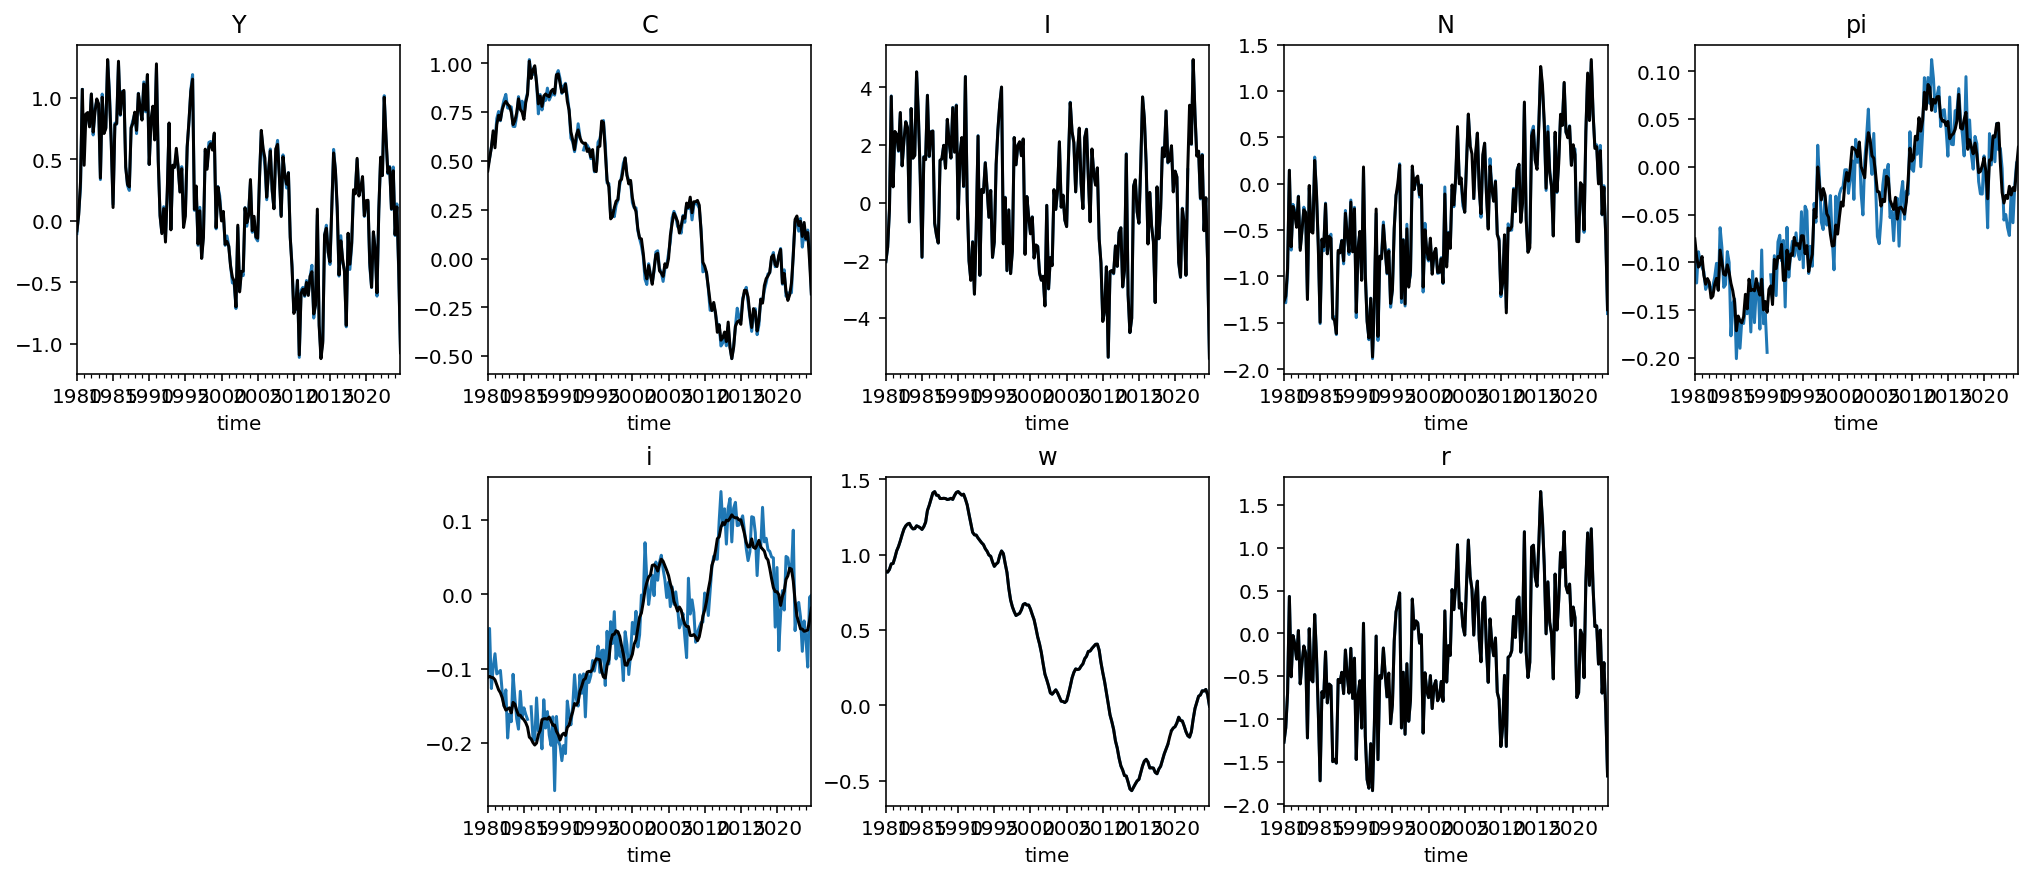

In [30]:
fig = plt.figure(figsize=(14, 6), dpi=144, layout="constrained")
gs, locs = gp.prepare_gridspec_figure(
    n_plots=len(ss_mod.observed_states), n_cols=5, figure=fig
)
for loc, col in zip(locs, data):
    axis = fig.add_subplot(gs[loc])
    data[col].plot(ax=axis, legend=False, title=col)
    latent_data[col].plot(ax=axis, legend=False, color="k")

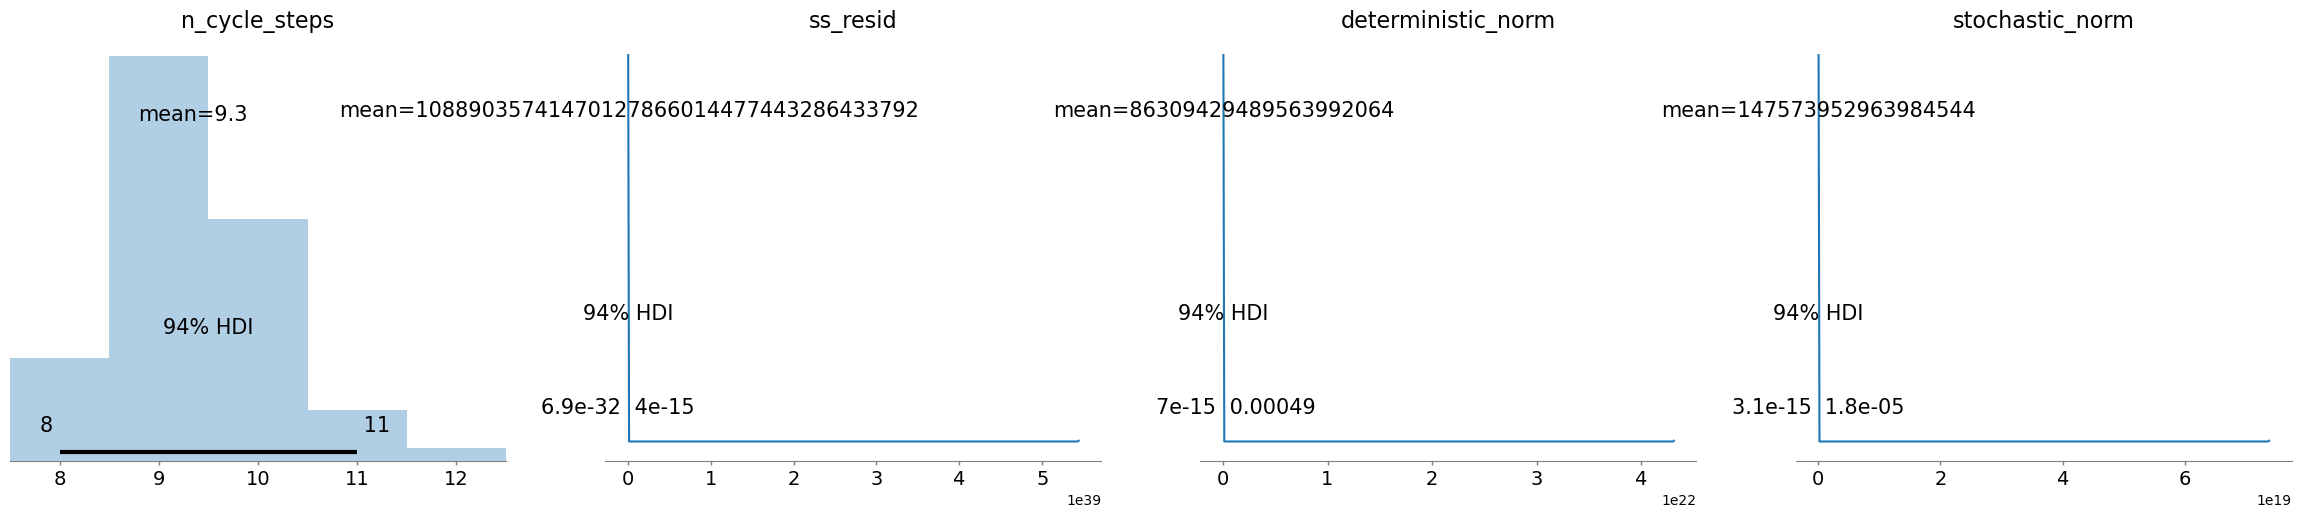

In [31]:
az.plot_posterior(
    prior_idata.prior,
    var_names=["n_cycle_steps", "ss_resid", "deterministic_norm", "stochastic_norm"],
);

In [32]:
ntp_mod = ntp.compile_pymc_model(
    freeze_dims_and_data(pm_mod),
    backend="jax",
    gradient_backend="jax",
    default_initialization_strategy="prior",
    jitter_rvs=set(),
    #                                  initial_points=None)
    initial_points={k: v for k, v in ss_mod.param_dict.items() if k in pm_mod},
)

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc/pytensorf.py:1066: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc/pytensorf.py:1066: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


In [33]:
idata = ntp.sample(
    ntp_mod.with_transform_adapt(
        verbose=True,
        learning_rate=1e-3,
        num_layers=3,
        nn_width=128,
        batch_size=512,
        #                                                 initial_skip=250,
        #                                                 num_diag_windows=11,
        zero_init=False,
        dct_layer=True,
        extend_dct=True,
    ),
    tune=1500,
    draws=1000,
    chains=6,
    #                    target_accept=0.95,
    transform_adapt=True,
)

seedseed 8274317945774394117
 7246178321982284643
seed 7840570666488713514
seed 15365025745911704303
seed 8295123372090351451
seed 18047251483928053709
Chain 0: Total available points: 11
seed 6893896678788945383
loss from diag: 8.2275319868954
Chain 5: Total available points: 11
seed 1062200666028841511
loss from diag: 7.923770280166446
Chain 1: Total available points: 11
seed 9022785903432812121
loss from diag: 7.423502257519867
Chain 2: Total available points: 11
seed 256390834338380119
loss from diag: 10.093817396113709
Chain 3: Total available points: 11
seed 15538983187733986222
loss from diag: 9.080835037318488
Chain 4: Total available points: 11
seed 13021466973748910452
loss from diag: 8.896215917252006
Chain 5: Total available points: 21
seed 1928331871650699857
loss from diag: 4.9286592833066445
Chain 1: Total available points: 21
seed 16873941559677745117
loss from diag: 3.3198173682546073
Chain 4: Total available points: 21
seed 14439350047874602538
loss from diag: 4.75552

Chain 4: Total available points: 351
Chain 4: New loss 3.5047708496175405, old loss 4.106559242276198
Chain 1: Total available points: 301
Chain 1: New loss 3.9069586818087987, old loss 4.546114736409245
Chain 2: Total available points: 251
Chain 2: New loss 4.030649510101847, old loss 5.131214280689487
Chain 3: Total available points: 301
Chain 3: New loss 3.827588568749403, old loss 4.48477753985185
Chain 5: Total available points: 351
Chain 5: New loss 3.4662630213516414, old loss 4.26772510935403
Chain 0: Total available points: 301
Chain 0: New loss 3.44032787246967, old loss 4.2980400194234445
Chain 4: Total available points: 401
Extending flow...
1.4072955327650054 [1.24465261 0.56846817 1.40729553 0.32594731 0.7971705  0.93596947
 1.19448627 0.48455366 0.83742573 0.90024264 0.63695362 0.9153032
 0.66712935 0.89266579 0.49733297 0.74362611 0.87324307 1.35743748
 0.46642734 0.69359429 0.58041733 0.39593777 0.51157657 0.40950888
 0.31302814 0.51644328 0.64871645 0.61082641 0.80813

Chain 4: New loss 3.101219444590664, old loss 3.4757704251969845
Chain 2: New loss 3.5624492338566167, old loss 4.0548586568325975
Chain 3: Total available points: 551
Chain 5: Total available points: 701
Chain 3: New loss 3.377506899148867, old loss 3.7196777442927287
Chain 5: New loss 2.8972551124278656, old loss 3.3123927249746545
Chain 0: Total available points: 551
Chain 1: Total available points: 651
Chain 0: New loss 3.443531424667228, old loss 3.68874233835527
Chain 4: Total available points: 751
Chain 1: New loss 3.1519408994453997, old loss 3.501775615239509
Chain 4: New loss 3.0786271853165506, old loss 3.411075060265331
Chain 5: Total available points: 751
Chain 2: Total available points: 451
Chain 3: Total available points: 601
Extending flow...
Chain 5: New loss 2.8918255729760194, old loss 3.1553398007697426
0.7545581469313445 [0.60358395 0.5839124  0.64922632 0.62522997 0.55627033 0.53871659
 0.61127033 0.58965019 0.63533095 0.5560895  0.73683166 0.69224927
 0.59913293 

Chain 4: Total available points: 1051
Chain 0: New loss 3.2057532320104296, old loss 3.8710689357434247
Chain 4: New loss 2.7012498375285325, old loss 2.9169037128144235
Chain 5: Total available points: 1051
Chain 5: New loss 2.553537813929278, old loss 3.0511801943790684
Chain 3: Total available points: 851
Chain 1: Total available points: 1001
Chain 3: New loss 3.031400485673138, old loss 3.293251736321394
Chain 1: New loss 2.9279477089197528, old loss 3.180990343218211
Chain 2: Total available points: 701
Chain 4: Total available points: 1101
Chain 2: New loss 2.9985148154947647, old loss 3.603441733505307
Chain 5: Total available points: 1101
Chain 4: New loss 2.701733211099064, old loss 3.1921932846755117
Chain 5: New loss 2.6334958711484933, old loss 2.8560667842478447
Chain 0: Total available points: 851
Chain 0: New loss 3.2069217691511955, old loss 3.626610167583845
Chain 1: Total available points: 1051
Chain 3: Total available points: 901
Chain 1: New loss 2.820812836010451, 

<Axes: >

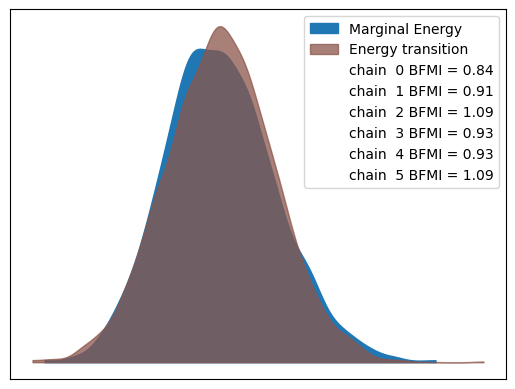

In [34]:
az.plot_energy(idata)

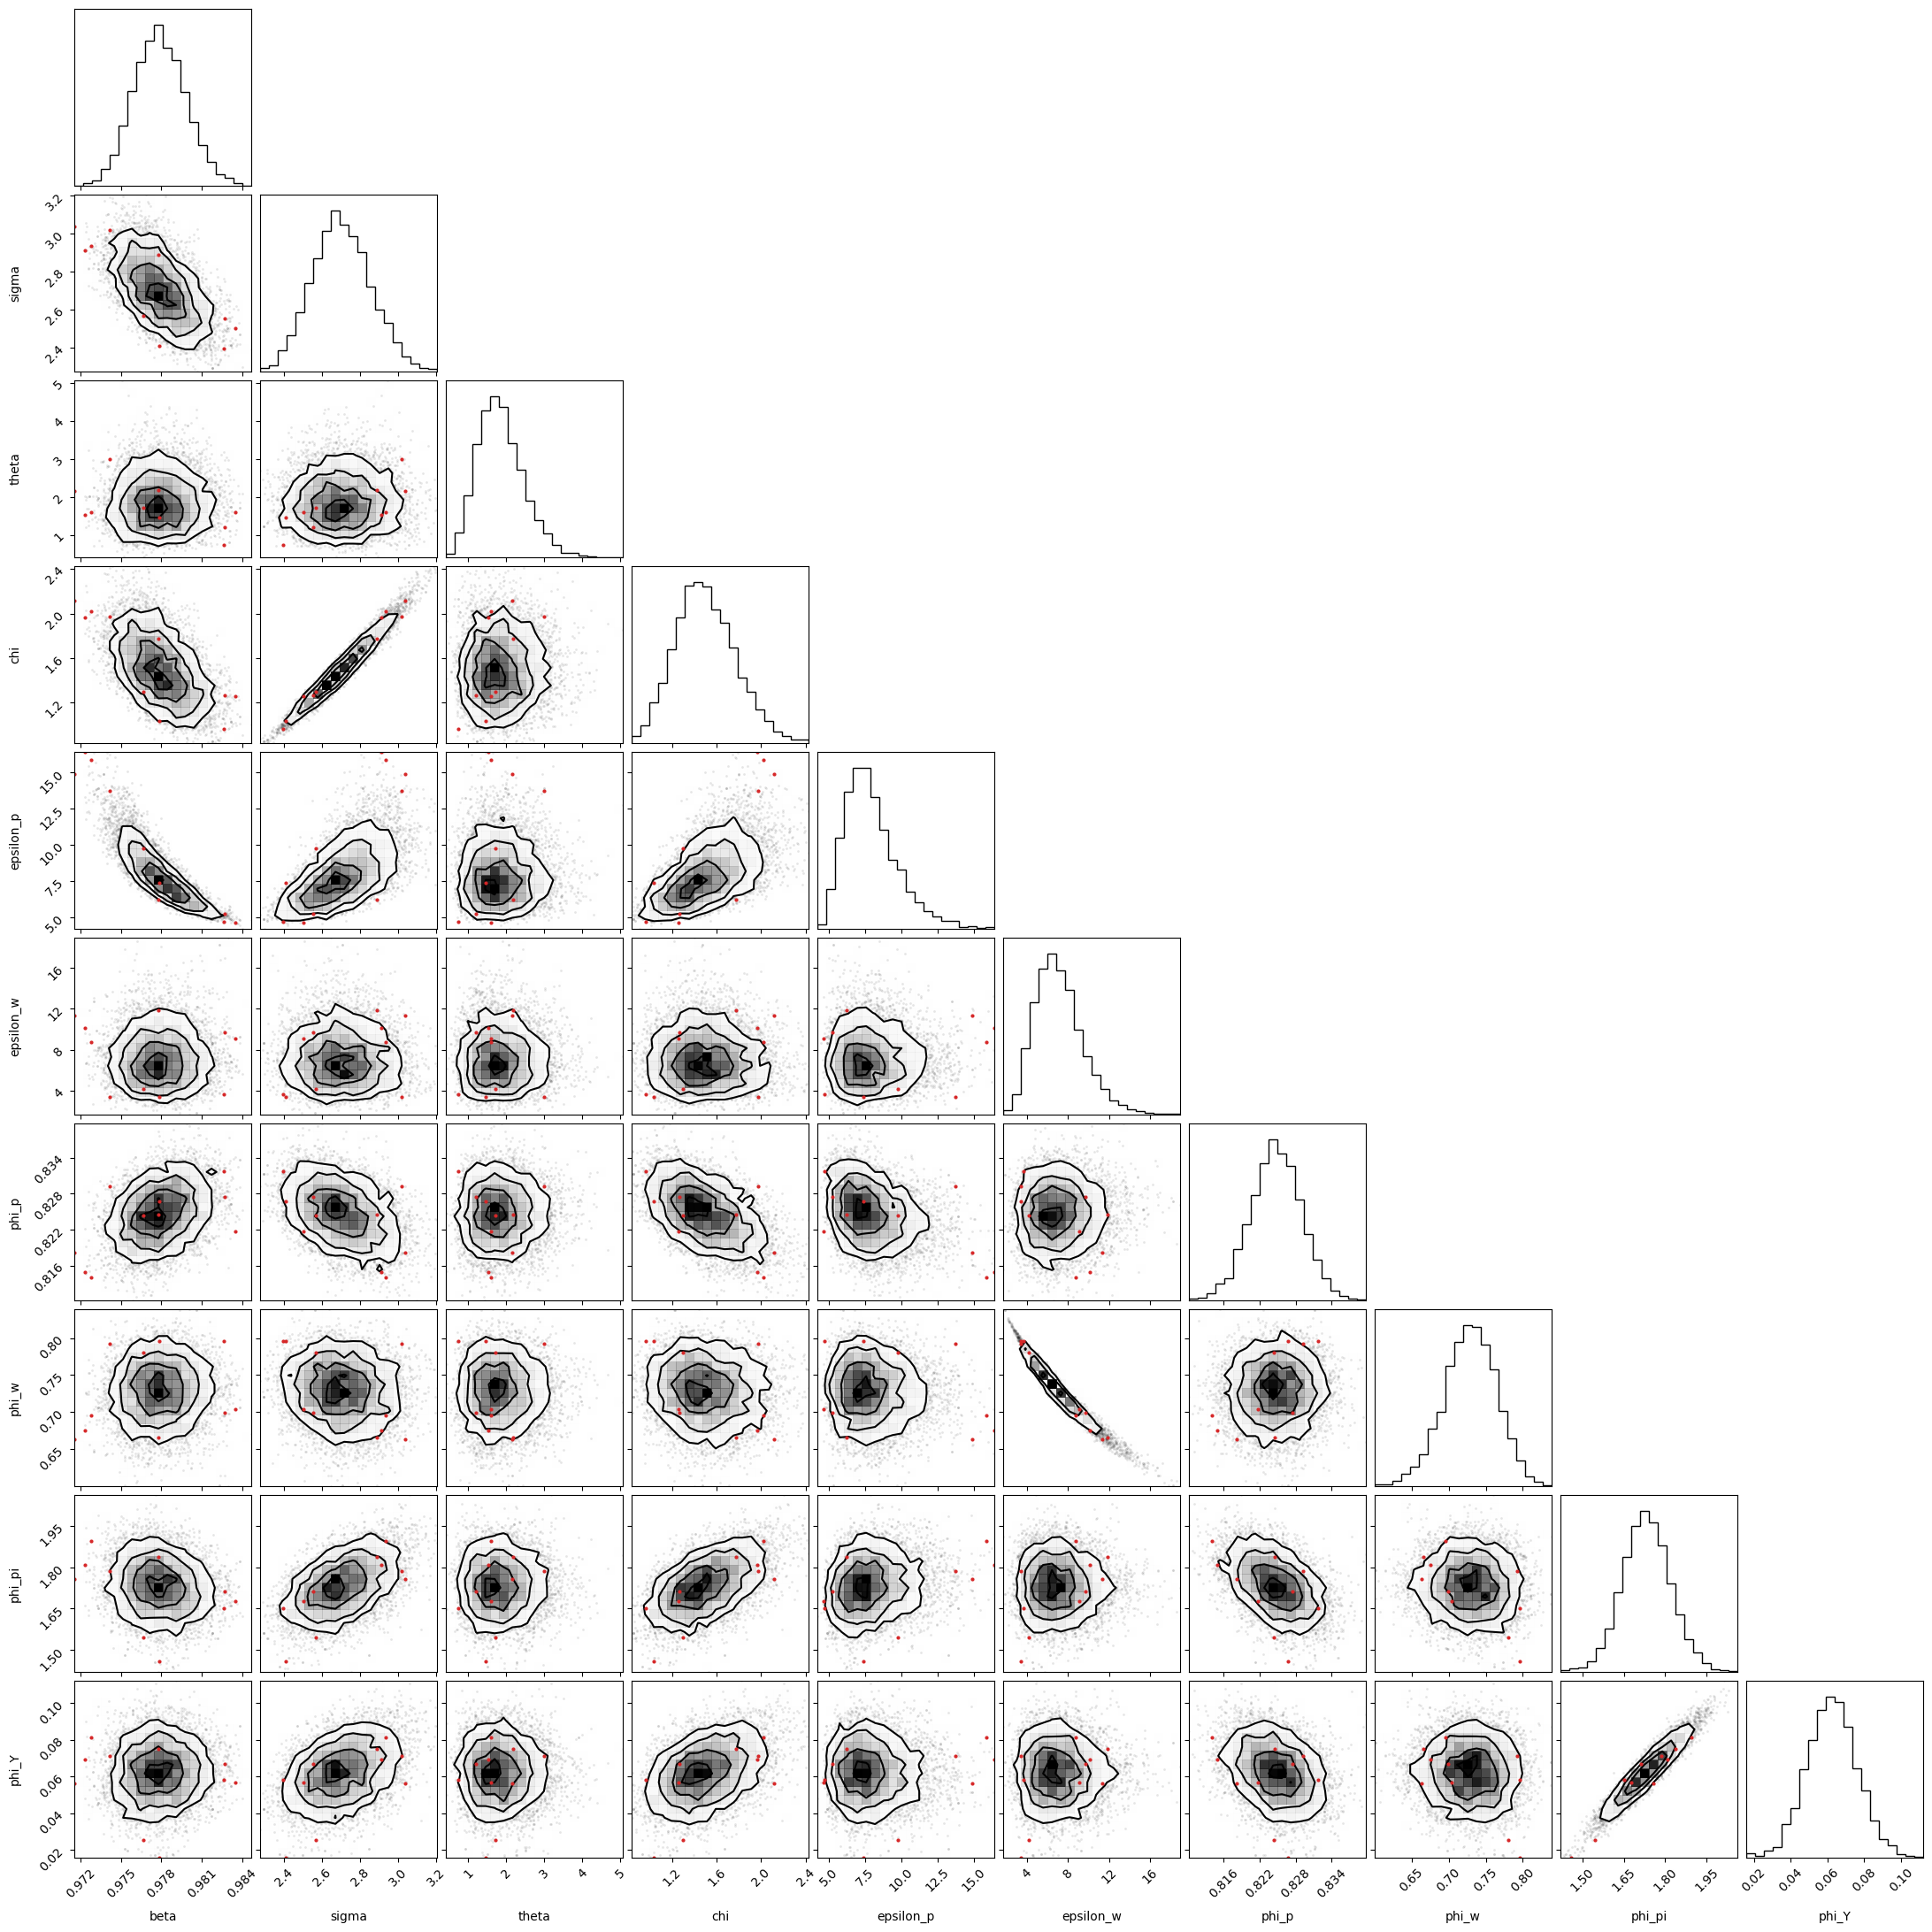

In [35]:
deep_params = [
    "beta",
    "sigma",
    "theta",
    "chi",
    "epsilon_p",
    "epsilon_w",
    "phi_p",
    "phi_w",
    "phi_pi",
    "phi_Y",
]
var_names = [rv.name for rv in pm_mod.free_RVs]
corner(
    idata,
    var_names=deep_params,
    divergences=True,
    divergences_kwargs={"markersize": 4, "color": "tab:red"},
);

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (45) in plot_posterior, generating only 40 plots
  warnings.warn(


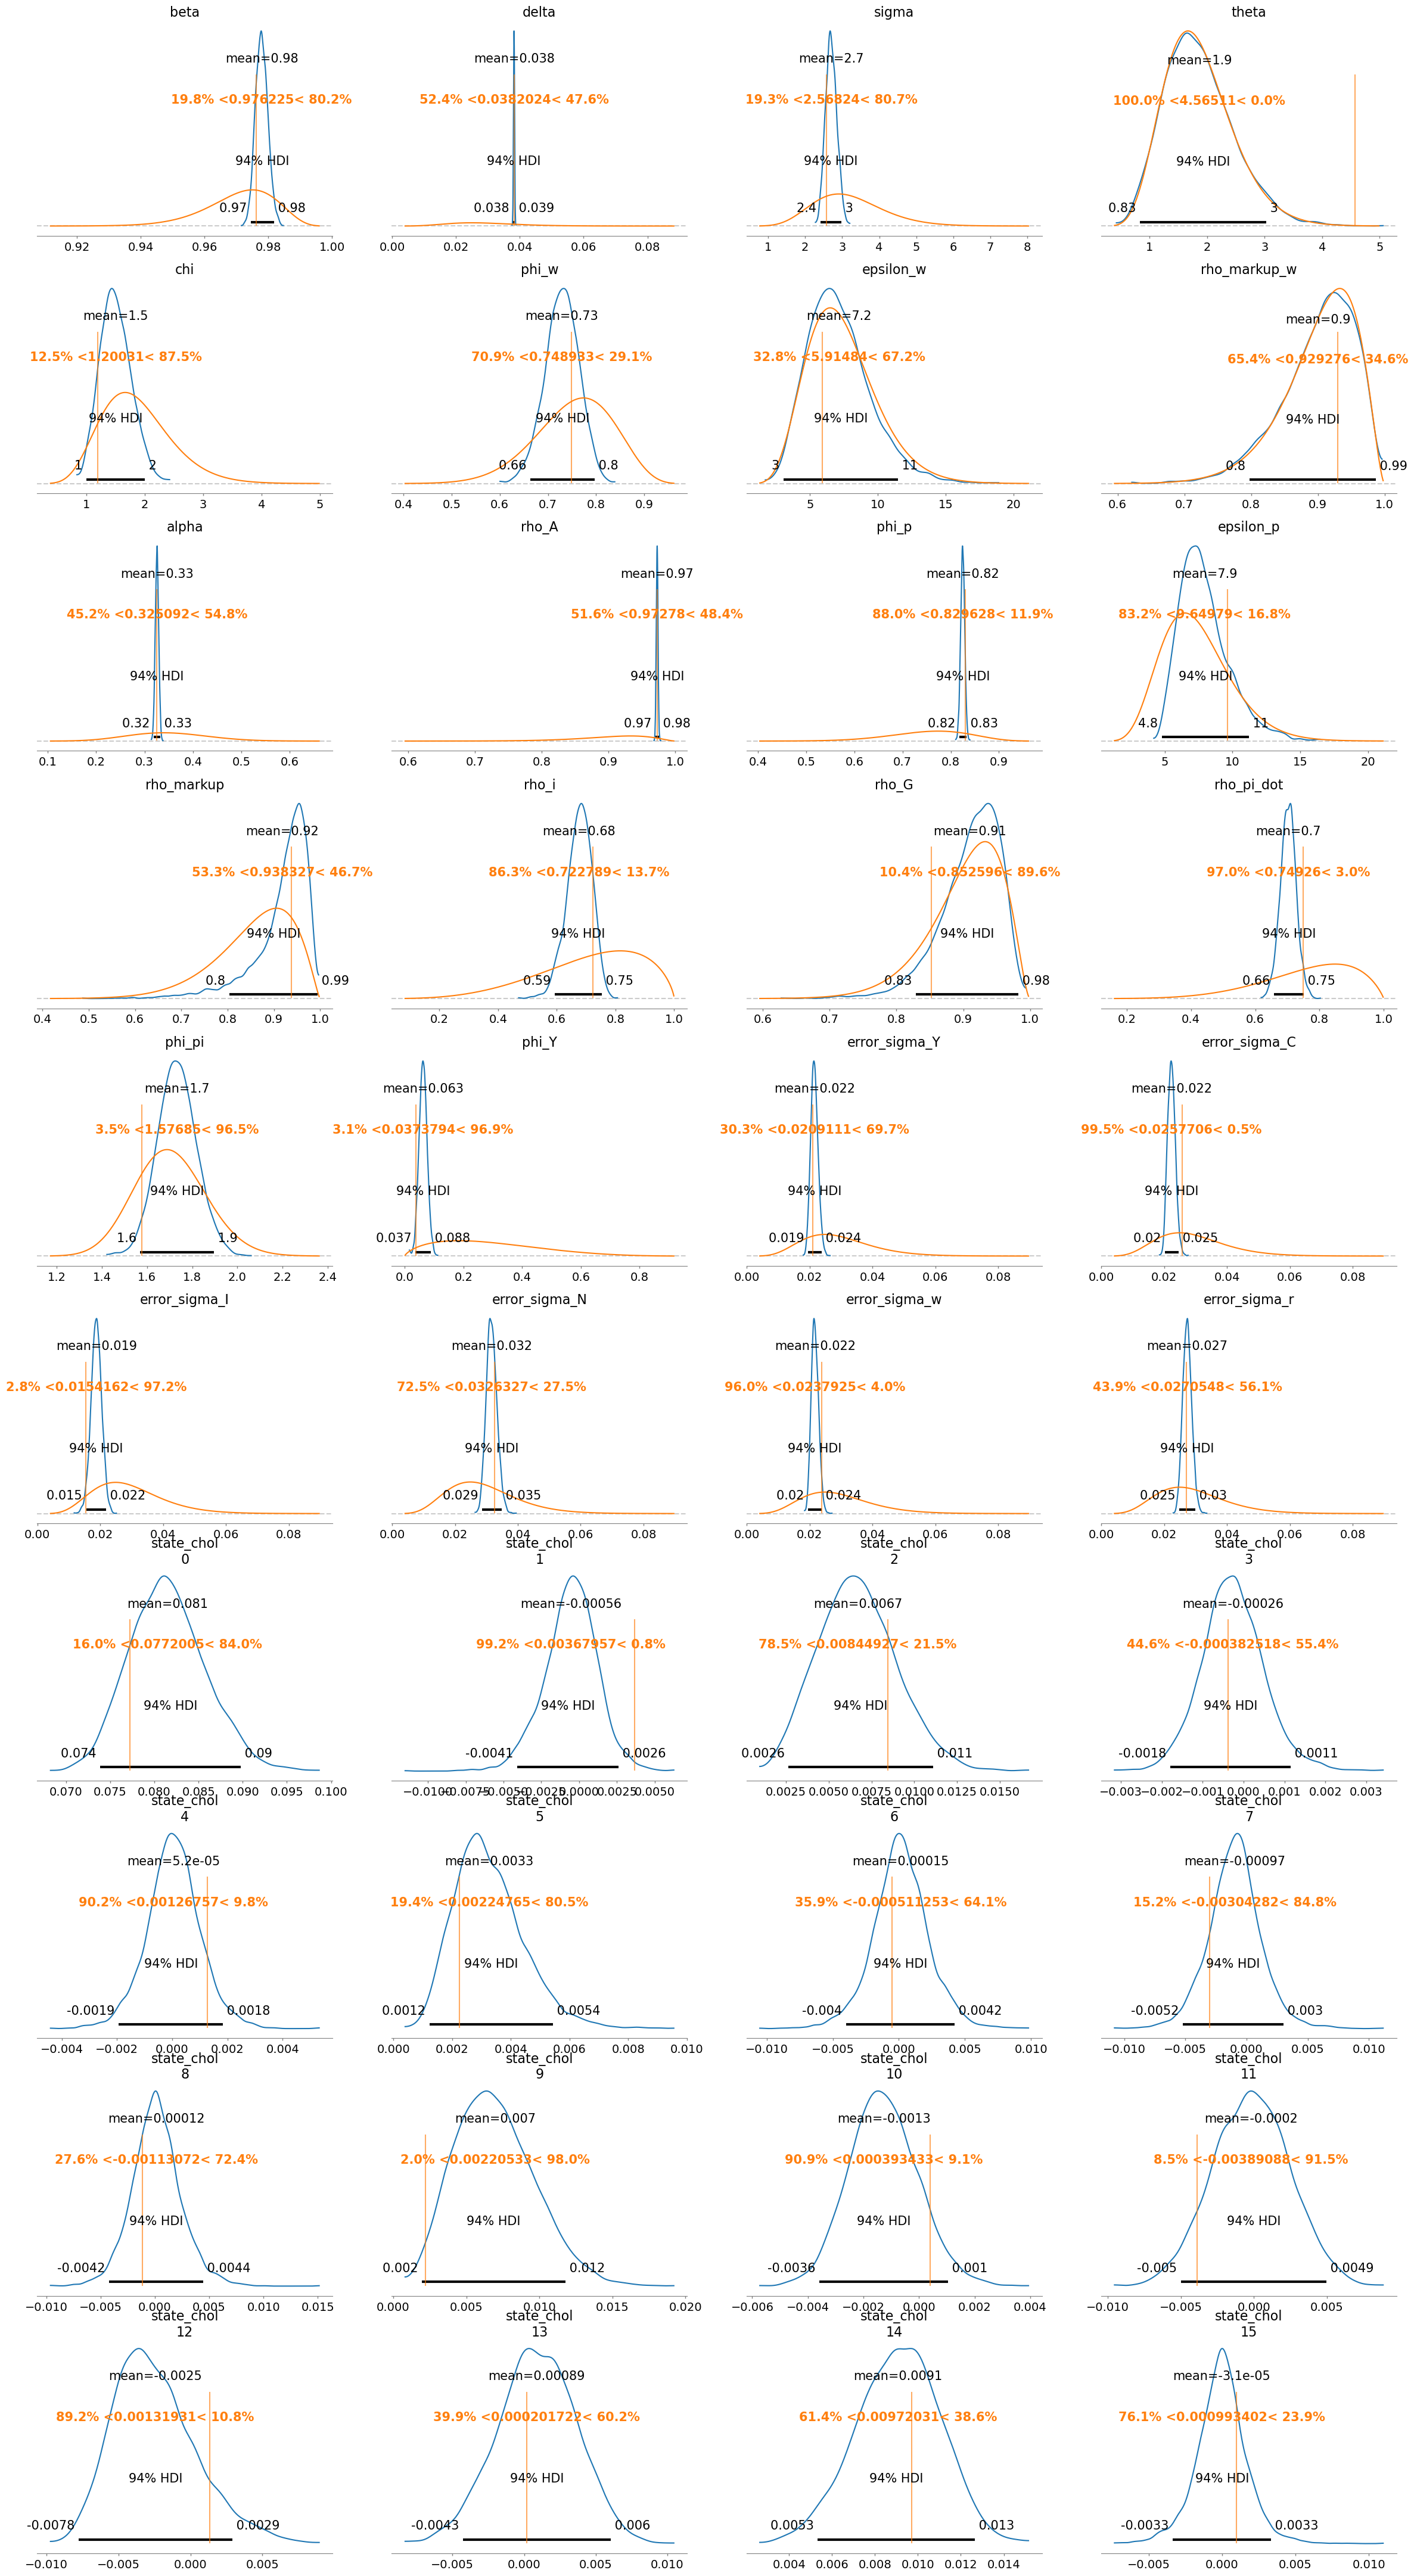

In [36]:
axes = az.plot_posterior(
    idata,
    var_names=var_names,
    ref_val=np.r_[*[true_params[name].values.ravel() for name in var_names]].tolist(),
)
for axis in axes.ravel():
    var_name, *coords = axis.get_title().split("\n")

    if var_name in all_priors:
        all_priors[var_name].plot_pdf(ax=axis, legend=False, color="tab:orange")

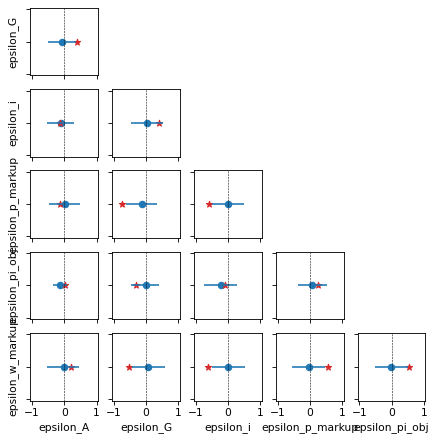

In [37]:
from itertools import product

n_shocks = ss_mod.k_posdef

fig, ax = plt.subplots(
    n_shocks,
    n_shocks,
    figsize=(8, 8),
    dpi=77,
    subplot_kw={"aspect": "equal"},
    sharex=True,
    sharey=True,
)

true_corr = true_params.state_chol_corr.values
mu = idata.posterior.state_chol_corr.mean(dim=["chain", "draw"])
hdi = az.hdi(idata.posterior.state_chol_corr).state_chol_corr
ax[0, 0].set(xlim=(-1.05, 1.05), ylim=(-1.05, 1.05))

for i, j in product(range(n_shocks), range(n_shocks)):
    axis = ax[i, j]
    if i <= j:
        axis.set_visible(False)
        continue
    y_var = mod.shocks[i].base_name
    x_var = mod.shocks[j].base_name
    axis.scatter(mu.values[i, j], 0)
    axis.scatter(true_corr[i, j], 0, marker="*", color="tab:red")

    axis.hlines(0, *hdi.values[i, j])
    axis.axvline(0, ls="--", c="k", lw=0.5)

    axis.set(
        ylabel=y_var if j == 0 else "",
        xlabel=x_var if i == (n_shocks - 1) else "",
        yticklabels=[],
    )

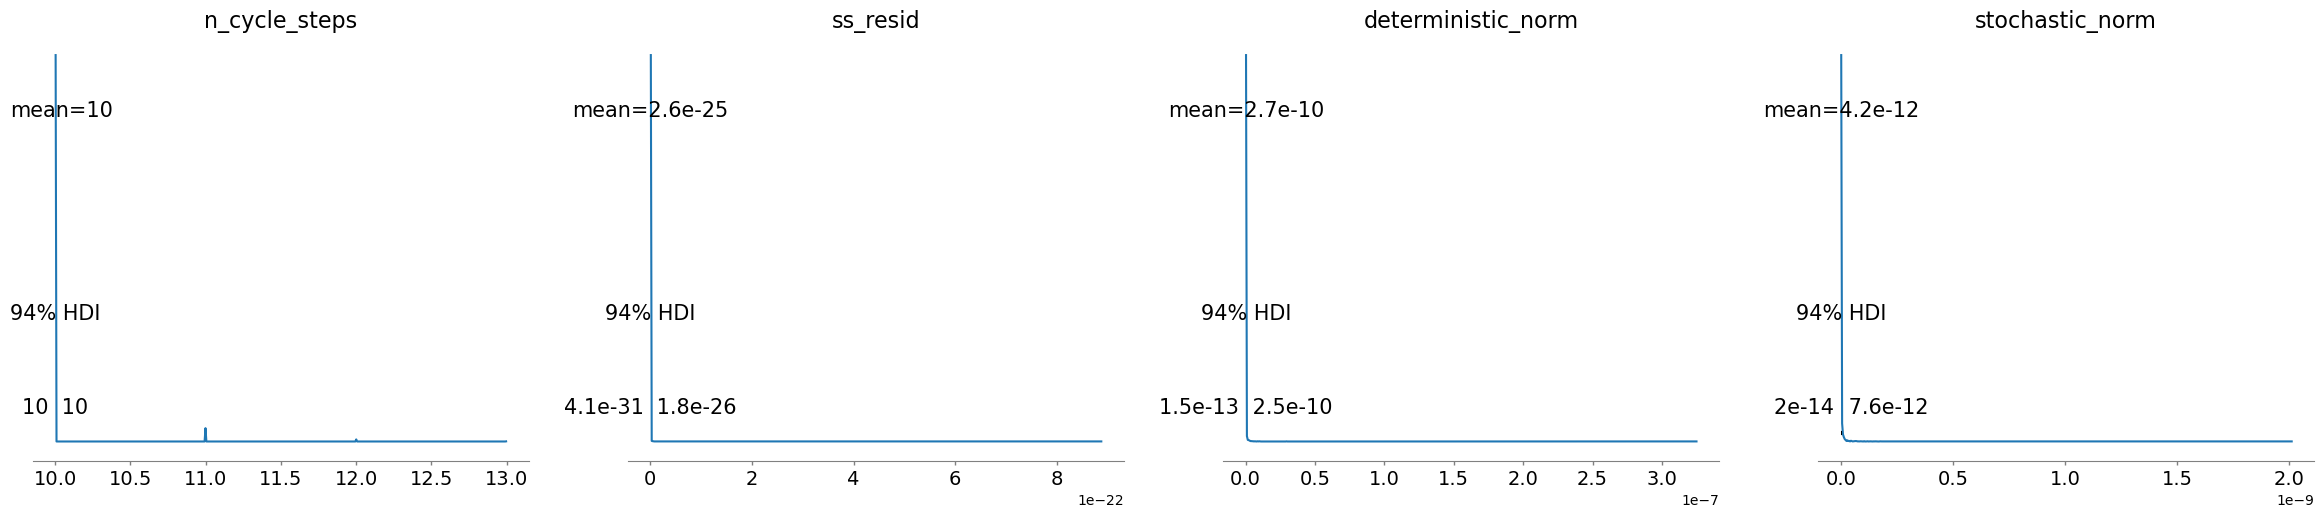

In [38]:
az.plot_posterior(
    idata,
    var_names=["n_cycle_steps", "ss_resid", "deterministic_norm", "stochastic_norm"],
);

In [39]:
cond_post = ss_mod.sample_conditional_posterior(idata)

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc_extras/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)
/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x3886AD460>), RNG(<Generator(PCG64) at 0x3886AD380>), RNG(<Generator(PCG64) at 0x3886AC3C0>), RNG(<Generator(PCG64) at 0x3886AC4A0>), RNG(<Generator(PCG64) at 0x3886AC580>), RNG(<Generator(PCG64) at 0xA86FC7AE0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

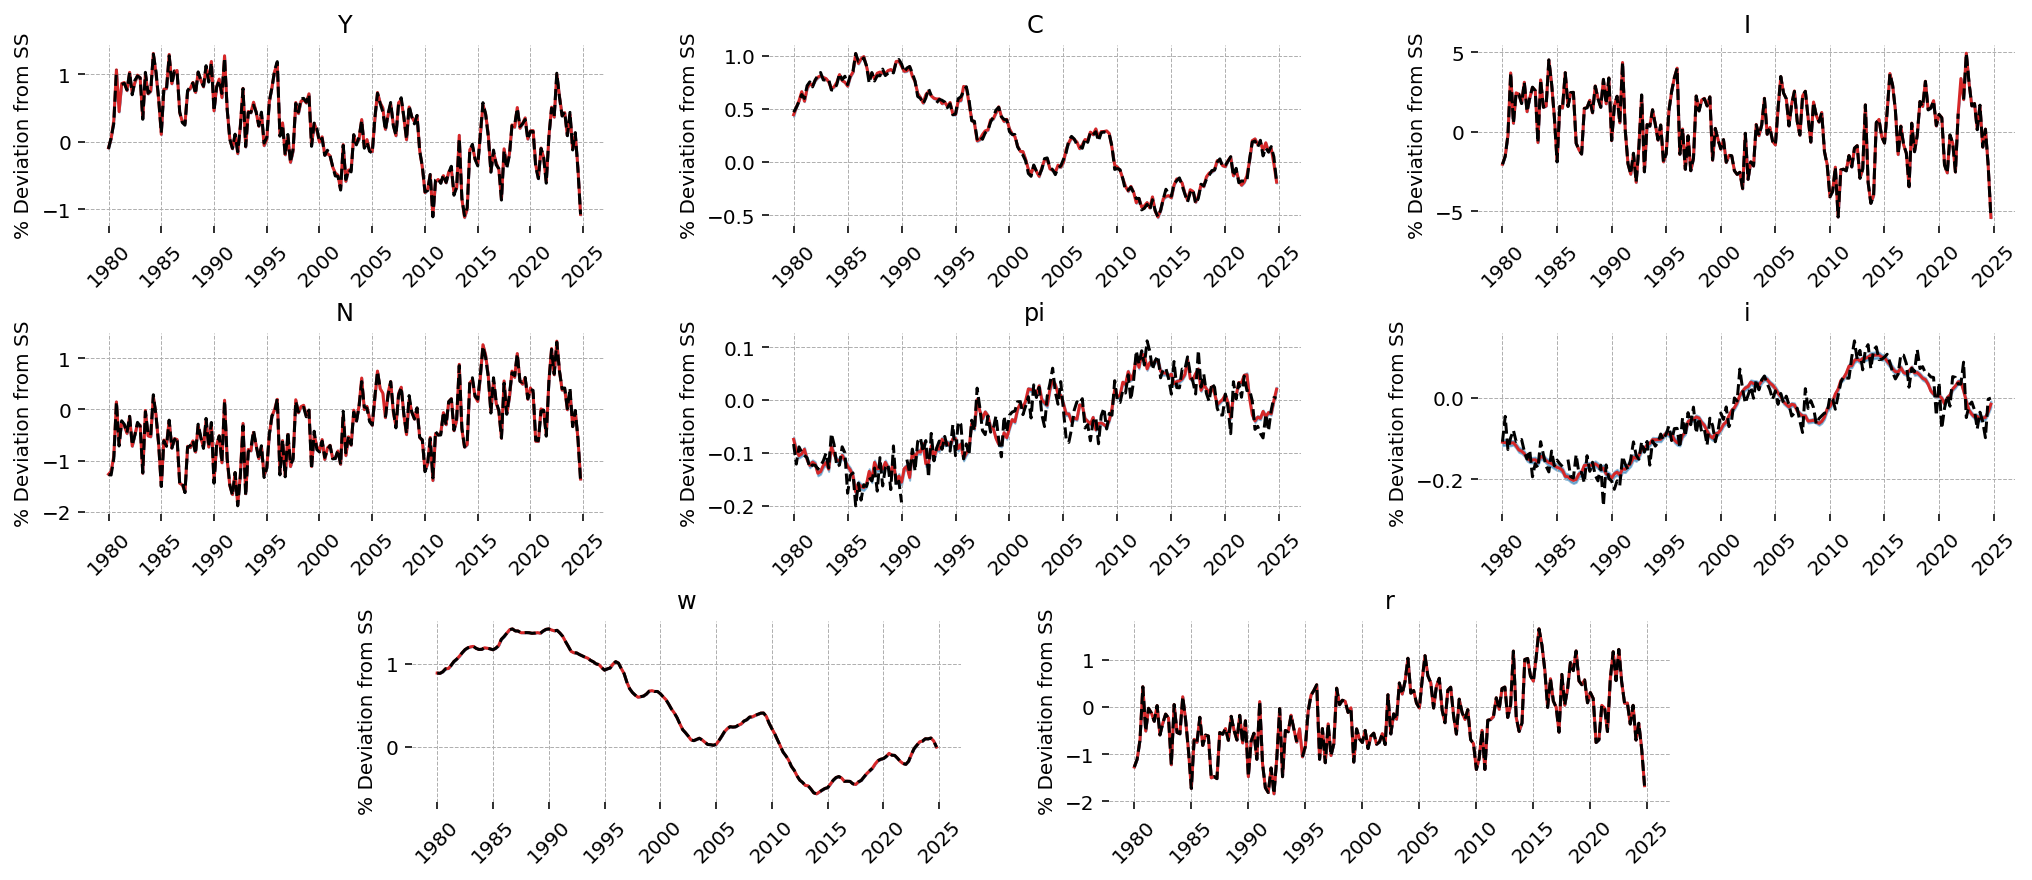

In [40]:
gp.plot_kalman_filter(
    cond_post,
    data,
    kalman_output="smoothed",
    n_cols=3,
    vars_to_plot=ss_mod.observed_states,
);

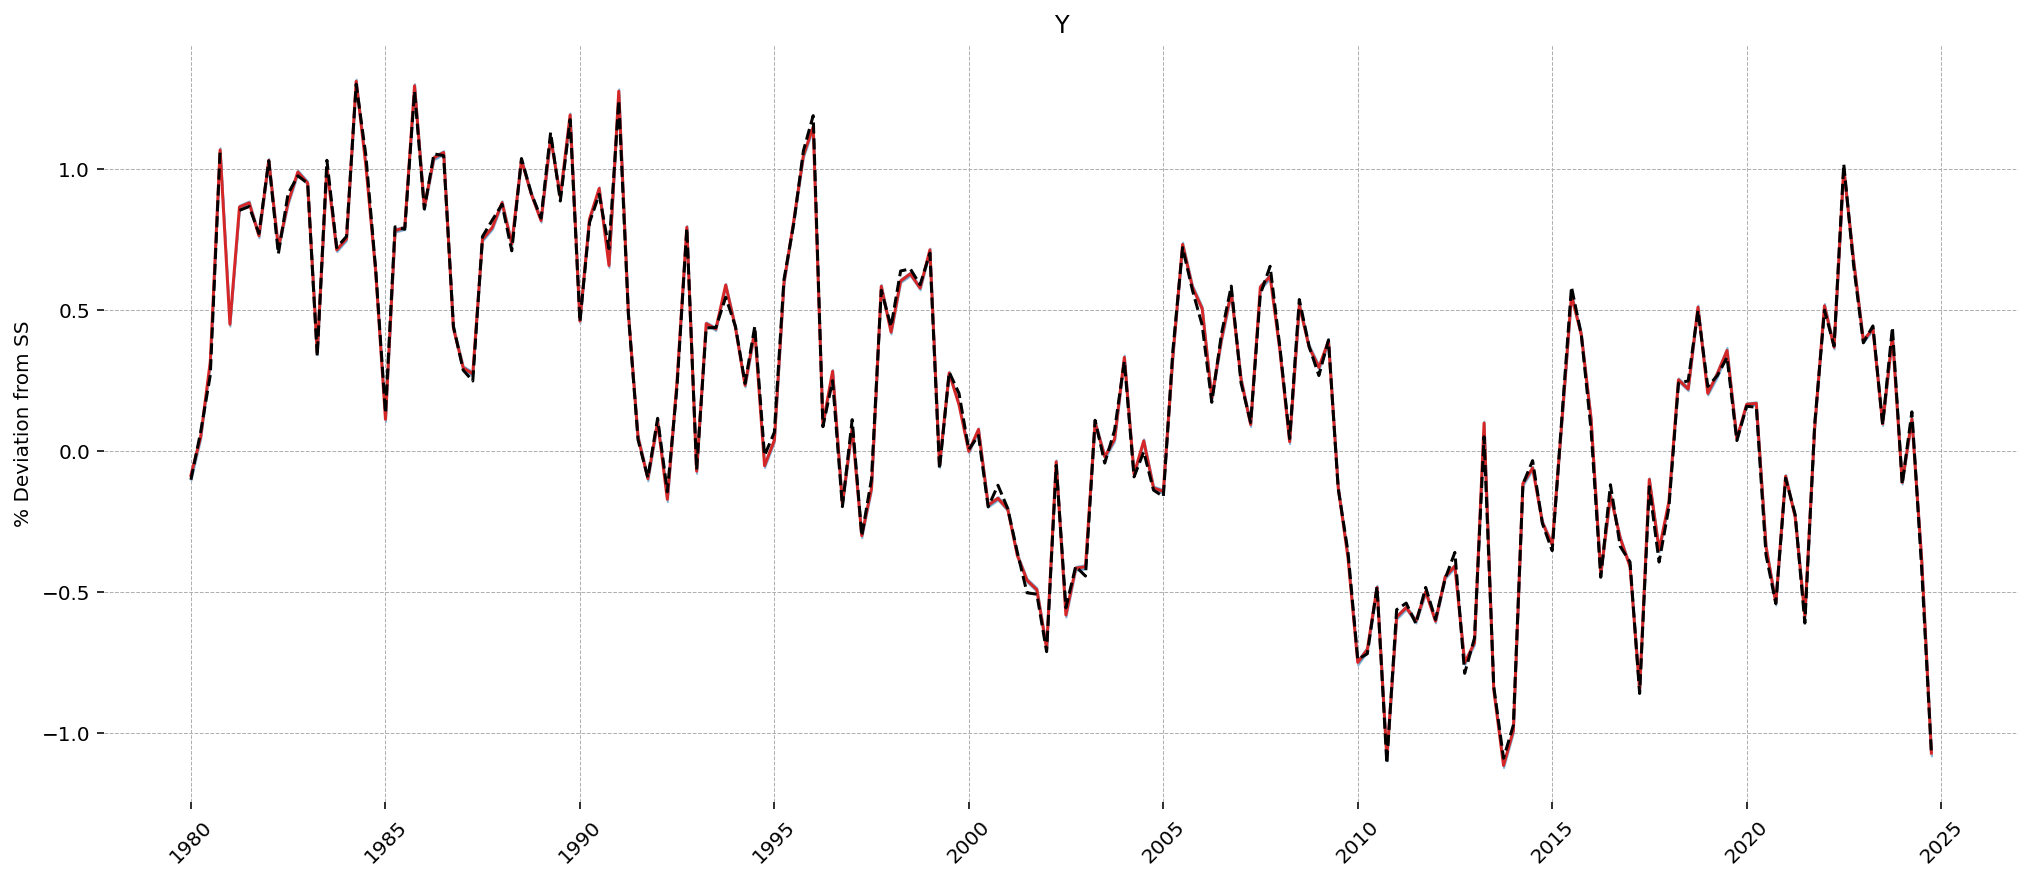

In [48]:
fig = gp.plot_kalman_filter(
    cond_post, data, kalman_output="smoothed", n_cols=1, vars_to_plot=["Y"]
)

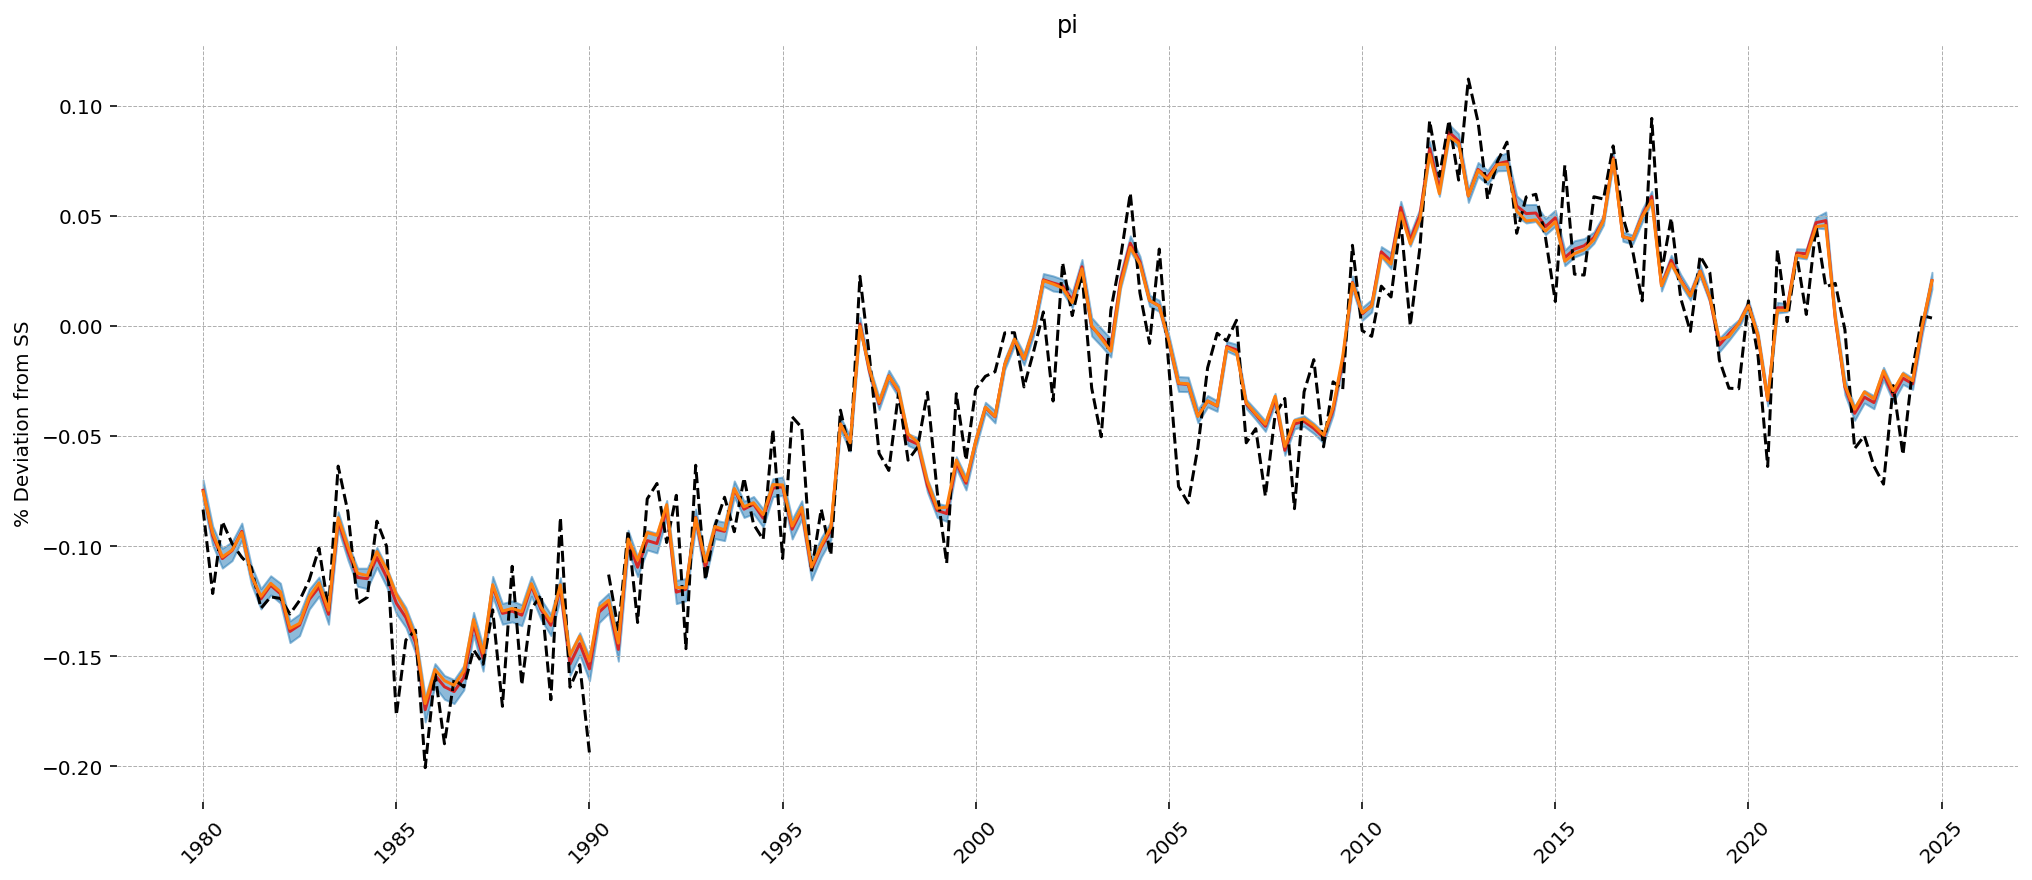

In [50]:
fig = gp.plot_kalman_filter(
    cond_post, data, kalman_output="smoothed", n_cols=1, vars_to_plot=["pi"]
)
ax = fig.axes[0]
ax.plot(latent_data.index, latent_data["pi"], color="tab:orange")

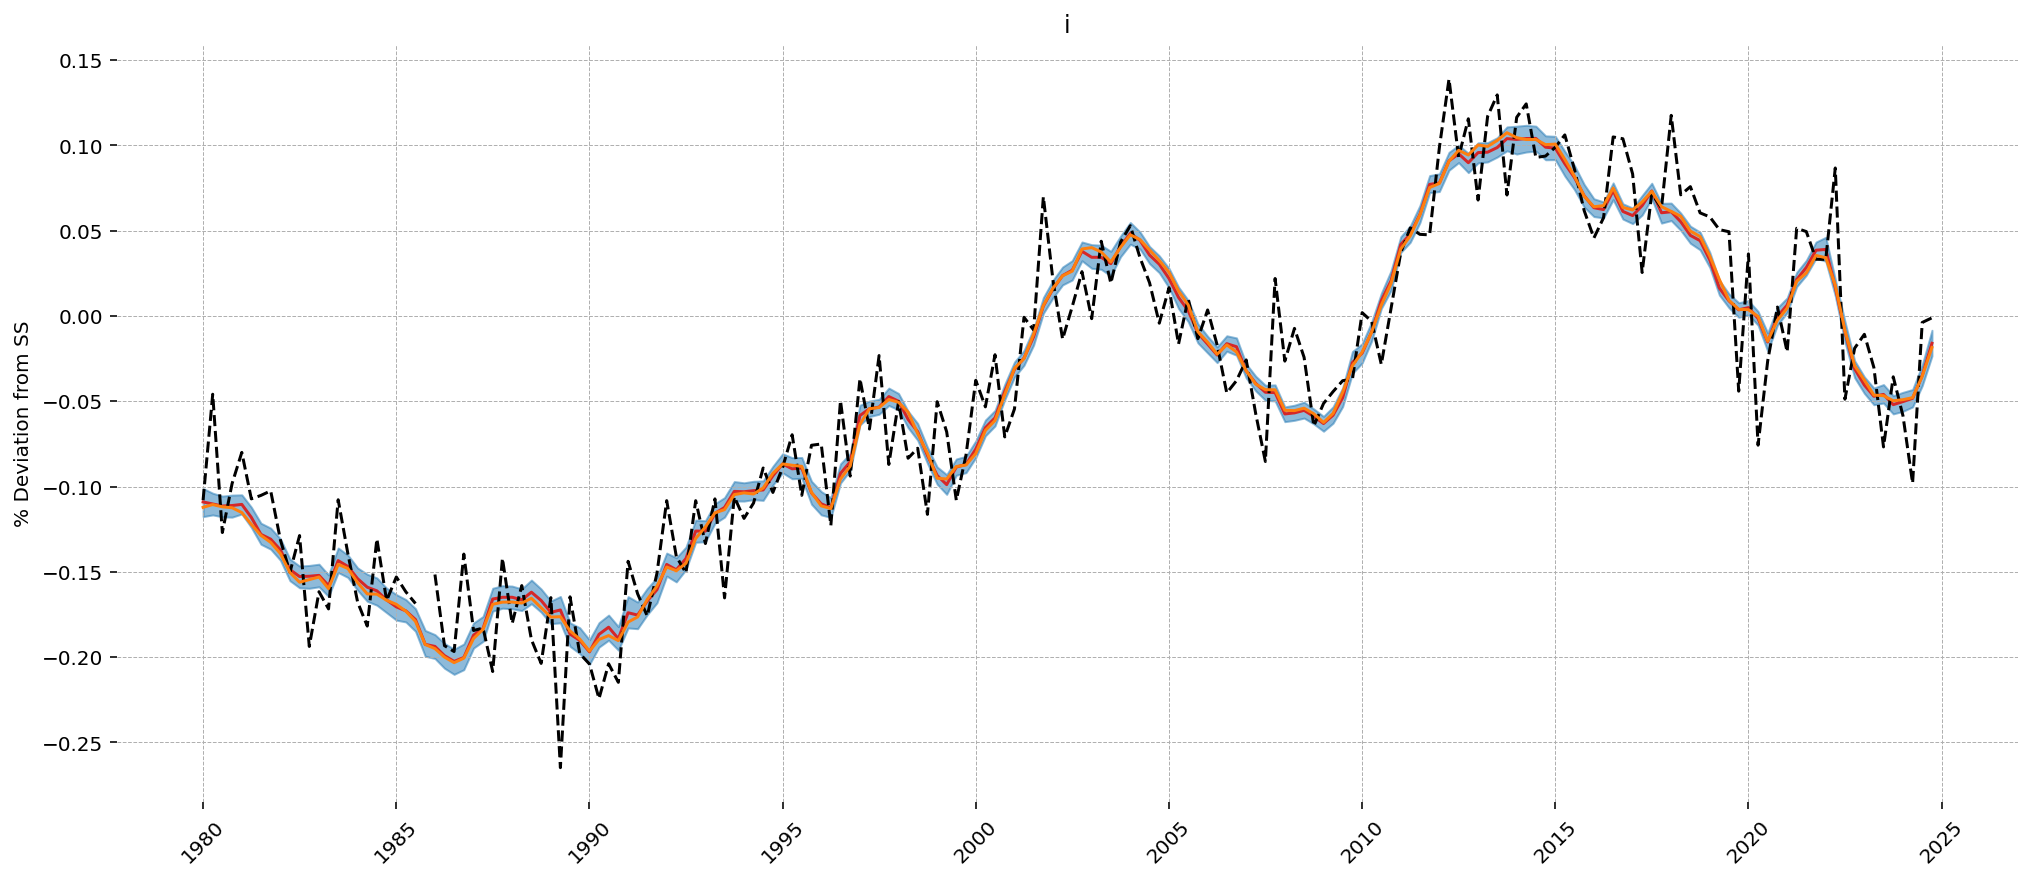

In [51]:
fig = gp.plot_kalman_filter(
    cond_post, data, kalman_output="smoothed", n_cols=1, vars_to_plot=["i"]
)
ax = fig.axes[0]
ax.plot(latent_data.index, latent_data["i"], color="tab:orange")

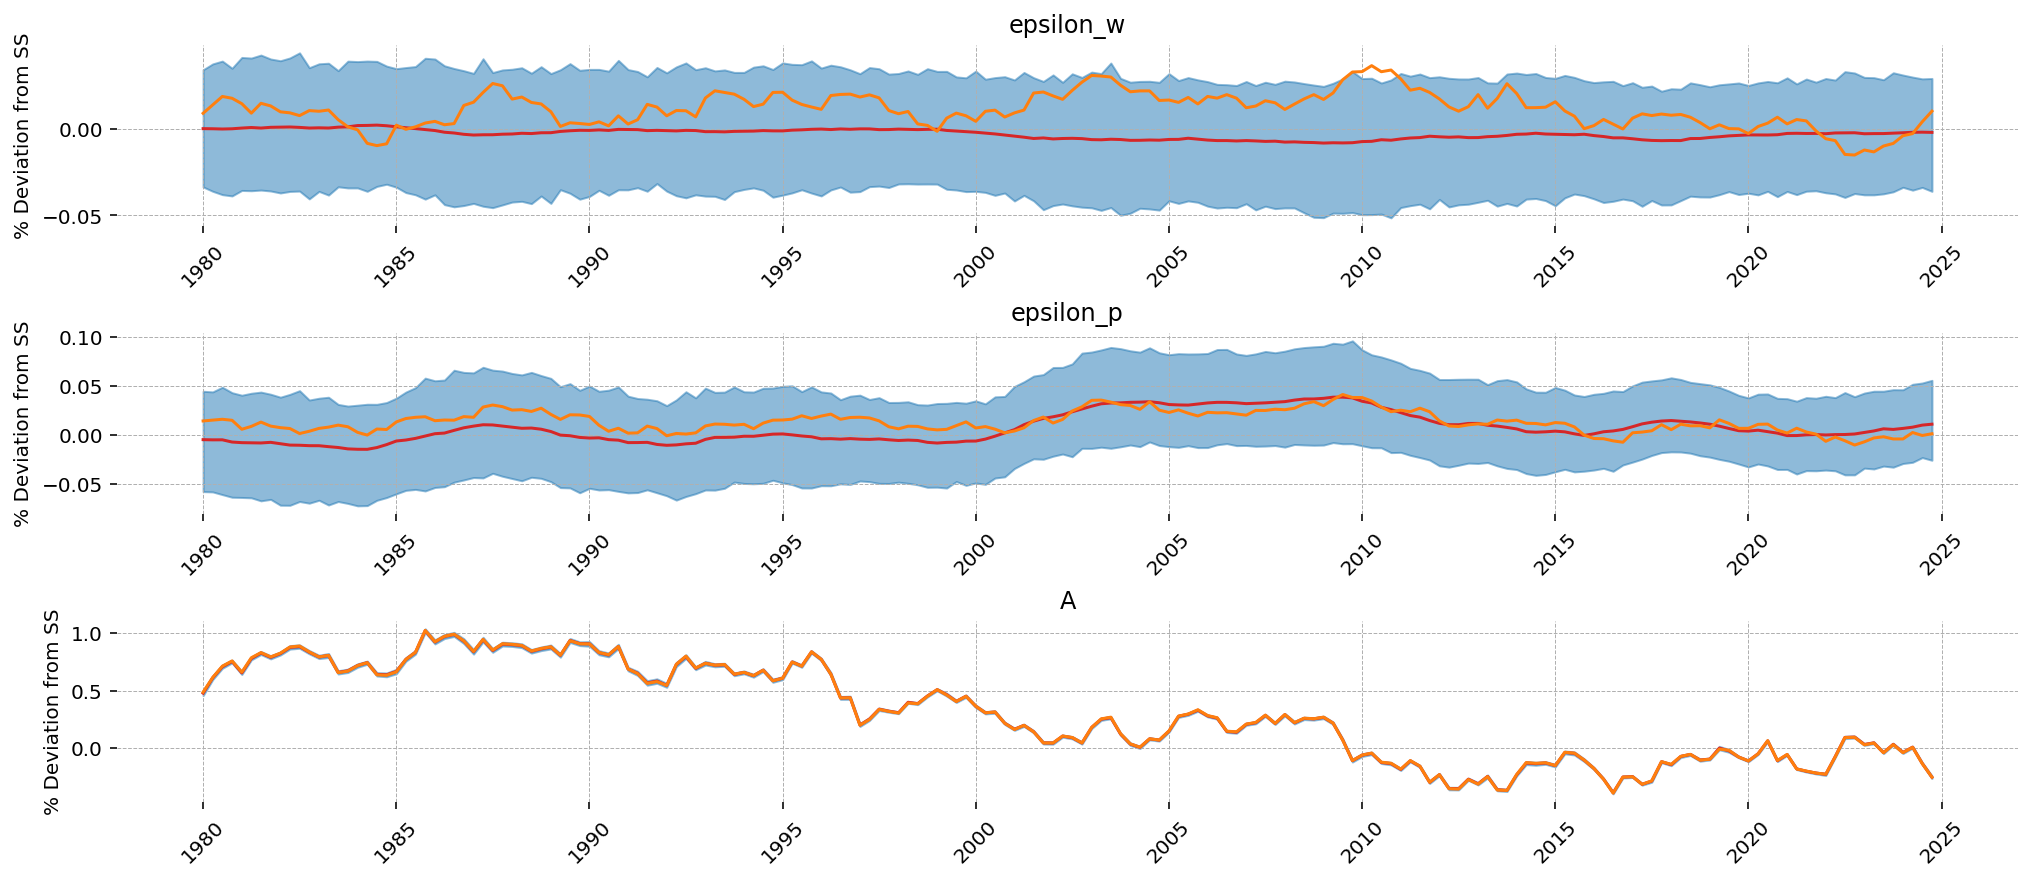

In [55]:
fig = gp.plot_kalman_filter(
    cond_post,
    data,
    kalman_output="smoothed",
    n_cols=1,
    vars_to_plot=["epsilon_w", "epsilon_p", "A"],
)
for axis in fig.axes:
    var = axis.get_title()
    axis.plot(latent_data.index, latent_data[var], color="tab:orange")